In [1]:
import time
import datetime
import torch
import random
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import scale

In [2]:
# для воспроизводимости эксперимента:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
timesample = 0.004
start_time = 1.0
end_time = 2.0
n_receivers = 80
n_timesamples = int((end_time - start_time)/timesample)

data = np.empty([1,2,n_receivers,n_timesamples])

In [4]:
n_models = 1100

for i in range(n_models):
    if (i+1) % 100 == 0:
        print(i+1,'/',n_models)
    data_Z = pd.read_csv('csv_models_Thomsen_saturated_full_formulae_Z\\model_{}.csv'.format(i+1))
    model_gather_Z = np.array(data_Z[data_Z.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    data_X = pd.read_csv('csv_models_Thomsen_saturated_full_formulae_X\\model_{}.csv'.format(i+1))
    model_gather_X = np.array(data_X[data_X.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    model_gather = np.vstack(([model_gather_Z],[model_gather_X]))
    model_gather = np.reshape(model_gather,(1,2,n_receivers,n_timesamples))
    
    data = np.vstack((data,model_gather))
    
data = data[1:]

100 / 1100
200 / 1100
300 / 1100
400 / 1100
500 / 1100
600 / 1100
700 / 1100
800 / 1100
900 / 1100
1000 / 1100
1100 / 1100


In [5]:
print(data.shape)

(1100, 2, 80, 250)


In [6]:
# центрирование и нормализация данных
for i in range(n_models):
    for j in range(2):
        data[i,j] = scale(data[i,j], axis=1)

In [16]:
frac_params = pd.read_csv('frac_params_Thomsen_saturated_full_formulae.csv')
frac_params = np.array(frac_params[['delta','gamma','e']])

In [17]:
X_train = torch.Tensor(data[:800])
X_validation = torch.Tensor(data[800:1100])

Y_train = torch.Tensor(frac_params[:800])
Y_validation = torch.Tensor(frac_params[800:1100])

In [18]:
#"""
class FracAnisotropyNet(torch.nn.Module):
    def __init__(self,n1,n2,n3):
        super(FracAnisotropyNet,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=n1, kernel_size=(2,4), padding=0, stride=2)
        self.ac1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=n1)
        #self.do1 = torch.nn.Dropout(p=prob)
        #self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=3, padding=0, stride=2)
        self.ac2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=n2)
        
        self.conv3 = torch.nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=(2,3), padding=1, stride=(1,2))
        self.ac3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=n3)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(10*15*n3,50)
        self.ac1_ = torch.nn.Tanh()
        #self.bn1_ = torch.nn.BatchNorm1d(num_features=50)
        self.fc2 = torch.nn.Linear(50,20)
        self.ac2_ = torch.nn.Tanh()
        #self.bn2_ = torch.nn.BatchNorm1d(num_features=20)
        
        self.out = torch.nn.Linear(20,3) 
        
    def forward(self,x):
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.ac1_(x)
        #x = self.bn1_(x)
        x = self.fc2(x)
        x = self.ac2_(x)
        #x = self.bn2_(x)
            
        x = self.out(x)
        
        return x
        
#"""

In [10]:
"""
# изменил кол-во нейронов в полносвязных слоях
class FracAnisotropyNet(torch.nn.Module):
    def __init__(self,n1,n2,n3,n4,prob=0.0):
        super(FracAnisotropyNet,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=n1, kernel_size=(2,4), padding=0, stride=2)
        self.ac1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=n1)
        self.do1 = torch.nn.Dropout(p=prob)
        #self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=2, padding=0, stride=(1,2))
        self.ac2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=n2)
        self.do2 = torch.nn.Dropout(p=prob)
        
        self.conv3 = torch.nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=(2,3), padding=1, stride=(1,2))
        self.ac3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=n3)
        self.do3 = torch.nn.Dropout(p=prob)
        
        self.conv4 = torch.nn.Conv2d(in_channels=n3, out_channels=n4, kernel_size=2, padding=0, stride=2)
        self.ac4 = torch.nn.ReLU()
        self.bn4 = torch.nn.BatchNorm2d(num_features=n4)
        self.do4 = torch.nn.Dropout(p=prob)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=(2,1), stride=(2,1))
        
        self.fc1 = torch.nn.Linear(10*15*n4,200)
        self.ac1_ = torch.nn.Tanh()
        #self.bn1_ = torch.nn.BatchNorm1d(num_features=100)
        self.fc2 = torch.nn.Linear(200,80)
        self.ac2_ = torch.nn.Tanh()
        #self.bn2_ = torch.nn.BatchNorm1d(num_features=40)
        self.fc3 = torch.nn.Linear(80,20)
        self.ac3_ = torch.nn.Tanh()
        
        self.out = torch.nn.Linear(20,1) 
        
    def forward(self,x):
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        x = self.do1(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        x = self.do2(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        x = self.do3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        #x = self.pool3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv4(x)
        x = self.ac4(x)
        x = self.bn4(x)
        x = self.do4(x)
        x = self.pool4(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.ac1_(x)
        #x = self.bn1_(x)
        x = self.fc2(x)
        x = self.ac2_(x)
        #x = self.bn2_(x)
        x = self.fc3(x)
        x = self.ac3_(x)
            
        x = self.out(x)
        
        return x
        
"""

"\n# изменил кол-во нейронов в полносвязных слоях\nclass FracAnisotropyNet(torch.nn.Module):\n    def __init__(self,n1,n2,n3,n4,prob=0.0):\n        super(FracAnisotropyNet,self).__init__()\n        \n        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=n1, kernel_size=(2,4), padding=0, stride=2)\n        self.ac1 = torch.nn.ReLU()\n        self.bn1 = torch.nn.BatchNorm2d(num_features=n1)\n        self.do1 = torch.nn.Dropout(p=prob)\n        #self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)\n        \n        self.conv2 = torch.nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=2, padding=0, stride=(1,2))\n        self.ac2 = torch.nn.ReLU()\n        self.bn2 = torch.nn.BatchNorm2d(num_features=n2)\n        self.do2 = torch.nn.Dropout(p=prob)\n        \n        self.conv3 = torch.nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=(2,3), padding=1, stride=(1,2))\n        self.ac3 = torch.nn.ReLU()\n        self.bn3 = torch.nn.BatchNorm2d(num_features=n3)\n     

In [19]:
device = torch.device('cpu')

neural_net = FracAnisotropyNet(4,6,2)
#neural_net = FracAnisotropyNet(4,6,4,2)
neural_net = neural_net.to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=3.0e-4)

In [20]:
batch_size = 100
N = len(X_train)

test_loss_history = []
train_loss_history = []

X_validation = X_validation.to(device)
Y_validation = Y_validation.to(device)

start_time = datetime.datetime.now()
epochs = 200

for epoch in range(epochs):
    order = np.random.permutation(N)
  
    loss_sum = 0.0
    for batch_init in range(0,N,batch_size):
        optimizer.zero_grad()
        neural_net.train()
    
        X_batch = X_train[order[batch_init:batch_init+batch_size]].to(device)
        y_batch = Y_train[order[batch_init:batch_init+batch_size]].to(device)
    
        pred = neural_net.forward(X_batch)
        #loss_value = weighted_loss(pred,y_batch)
        loss_value = loss(pred,y_batch)
        loss_sum += loss_value
        loss_value.backward()
    
        optimizer.step()
    
    neural_net.eval()
    pred = neural_net.forward(X_validation)
  
    tr_l = loss_sum/(N/batch_size)
    te_l = loss(pred,Y_validation)
    train_loss_history.append(tr_l.data.cpu())
    test_loss_history.append(te_l.data.cpu())
  
    print('epoch #', epoch+1,':\n\tTrain Loss:\t',tr_l.data.cpu().numpy(),'\n\tTest Loss:\t',te_l.data.cpu().numpy())

educ_time = datetime.datetime.now() - start_time
print('Time elapsed:', educ_time)

epoch # 1 :
	Train Loss:	 0.0024388572 
	Test Loss:	 0.015431831
epoch # 2 :
	Train Loss:	 0.0008093424 
	Test Loss:	 0.014106828
epoch # 3 :
	Train Loss:	 0.0002844716 
	Test Loss:	 0.011804804
epoch # 4 :
	Train Loss:	 0.000118228374 
	Test Loss:	 0.0064915745
epoch # 5 :
	Train Loss:	 6.4228574e-05 
	Test Loss:	 0.0025188117
epoch # 6 :
	Train Loss:	 4.0090763e-05 
	Test Loss:	 0.0004890639
epoch # 7 :
	Train Loss:	 1.9440176e-05 
	Test Loss:	 6.285063e-05
epoch # 8 :
	Train Loss:	 1.4795827e-05 
	Test Loss:	 2.3798186e-05
epoch # 9 :
	Train Loss:	 1.2729918e-05 
	Test Loss:	 1.4159567e-05
epoch # 10 :
	Train Loss:	 8.1122325e-06 
	Test Loss:	 4.7570256e-06
epoch # 11 :
	Train Loss:	 5.7963875e-06 
	Test Loss:	 5.253581e-06
epoch # 12 :
	Train Loss:	 6.111861e-06 
	Test Loss:	 3.7927043e-06
epoch # 13 :
	Train Loss:	 4.8818556e-06 
	Test Loss:	 3.2251037e-06
epoch # 14 :
	Train Loss:	 5.289075e-06 
	Test Loss:	 4.6444666e-06
epoch # 15 :
	Train Loss:	 6.201709e-06 
	Test Loss:	 3.88

epoch # 122 :
	Train Loss:	 8.5359925e-06 
	Test Loss:	 1.9970632e-05
epoch # 123 :
	Train Loss:	 1.2337408e-05 
	Test Loss:	 2.051894e-06
epoch # 124 :
	Train Loss:	 4.901484e-06 
	Test Loss:	 1.378284e-07
epoch # 125 :
	Train Loss:	 2.3571495e-06 
	Test Loss:	 4.16683e-06
epoch # 126 :
	Train Loss:	 1.8391834e-06 
	Test Loss:	 1.5300012e-07
epoch # 127 :
	Train Loss:	 3.5259955e-06 
	Test Loss:	 1.4592506e-07
epoch # 128 :
	Train Loss:	 4.8026077e-06 
	Test Loss:	 1.4987028e-06
epoch # 129 :
	Train Loss:	 2.5295903e-06 
	Test Loss:	 1.5679751e-06
epoch # 130 :
	Train Loss:	 2.982104e-06 
	Test Loss:	 2.2658248e-06
epoch # 131 :
	Train Loss:	 2.821245e-06 
	Test Loss:	 4.7755593e-06
epoch # 132 :
	Train Loss:	 5.9009208e-06 
	Test Loss:	 3.394457e-06
epoch # 133 :
	Train Loss:	 3.1620782e-06 
	Test Loss:	 3.4687212e-06
epoch # 134 :
	Train Loss:	 2.857957e-06 
	Test Loss:	 1.03998e-06
epoch # 135 :
	Train Loss:	 4.4670046e-06 
	Test Loss:	 6.844131e-06
epoch # 136 :
	Train Loss:	 7.69

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
num = 30
def moving_average(a, n=num): # среднее скользящее среднее
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

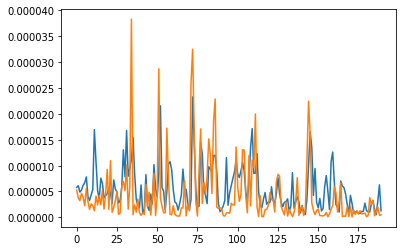

In [22]:
plt.plot(train_loss_history[10:])
plt.plot(test_loss_history[10:])

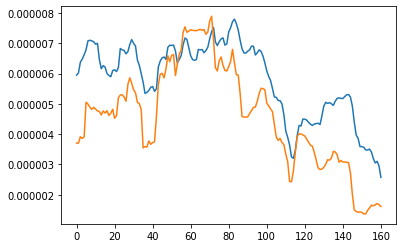

In [23]:
avg_loss_train = moving_average(train_loss_history)
avg_loss_test = moving_average(test_loss_history)
plt.plot(avg_loss_train[10:])
plt.plot(avg_loss_test[10:])

In [ ]:
print('Train Loss: ', avg_loss_train[-1])
print('Test Loss:  ', avg_loss_test[-1])

In [ ]:
pred = neural_net.forward(X_validation)
pred = pred.data.cpu().numpy()
y_val = Y_validation.data.cpu().numpy()
print('Predicted\tReal value\tDifference')
sum_delta = 0.0
sum_gamma = 0.0
sum_e = 0.0
sum_delta_sq = 0.0
sum_gamma_sq = 0.0
sum_e_sq = 0.0
sum_delta_real = 0.0
sum_gamma_real = 0.0
sum_e_real = 0.0
for i in range(300):
    dif = abs(pred[i]-y_val[i])
    print(pred[i],'\t',y_val[i],'\t',dif)
    
    sum_delta += dif[0]
    sum_gamma += dif[1]
    sum_e += dif[2]
    
    sum_delta_sq += dif[0]**2
    sum_gamma_sq += dif[1]**2
    sum_e_sq += dif[2]**2
    
    sum_delta_real += y_val[i][0]
    sum_gamma_real += y_val[i][1]
    sum_e_real += y_val[i][2]

mean_delta_sq = sum_delta_sq/300
mean_gamma_sq = sum_gamma_sq/300
mean_e_sq = sum_e_sq/300

In [ ]:
print('Mean delta difference: ', sum_delta/300)
print('Mean gamma difference: ', sum_gamma/300)
print('Mean e (crack density) difference: ', sum_e/300)

print('\nDelta MSE: ', math.sqrt(mean_delta_sq))
print('Gamma MSE: ', math.sqrt(mean_gamma_sq))
print('e MSE: ', math.sqrt(mean_e_sq))

#print(mean_asp_real)
print('\nRelative delta accuracy: ', sum_delta/abs(sum_delta_real))
print('Relative gamma accuracy: ', sum_gamma/abs(sum_gamma_real))
print('Relative e (crack density) accuracy: ', sum_e/sum_e_real)
#print('Mean dn difference: ', sum_dn/300)
#print('dn MSE: ', math.sqrt(sum_dn_sq/300))
#print('\nRelative dn accuracy: ', sum_dn/sum_dn_real)

In [ ]:
# проверим как предсказанные значения связаны с аналитической формулой
Vs = 2750
Vp = 5000
g = (Vs**2)/(Vp**2)
print('e (crack density)\tDelta formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][2]
    dn = 0
    dt = 16*e_pred/(3*(3-2*g))
    formula = -2*g*((1-2*g)*dn + dt)*(1-(1-2*g)*dn)/( (1-dn*(1-2*g)**2)*(1+(g*dt - dn*(1-2*g)**2)/(1-g)) )
    delta_pred = pred[i][0]
    dif = abs(delta_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',delta_pred,'\t',dif)

In [ ]:
print('Mean difference between predicted value and formula for delta: ', sum_dif/300)
print('Relative difference between predicted value and formula for delta: ', sum_dif/abs(sum_delta_real))

In [ ]:
print('e (crack density)\tGamma formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][2]
    dt = 16*e_pred/(3*(3-2*g))
    formula = -1*dt/2
    gamma_pred = pred[i][1]
    dif = abs(gamma_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',gamma_pred,'\t',dif)

In [ ]:
print('Mean difference between predicted value and formula for gamma: ', sum_dif/300)
print('Relative difference between predicted value and formula for gamma: ', sum_dif/abs(sum_gamma_real))